In [1]:
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score
from keras.utils import to_categorical
from sklearn.linear_model import SGDClassifier
from plotly.offline import init_notebook_mode, iplot
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import tensorflow as tf
import imblearn
from imblearn.over_sampling import SMOTE
from numpy import argmax
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D


warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
application_train = pd.read_csv('application_train.csv')
print('application_train shape = ',application_train.shape)

bureau = pd.read_csv('bureau.csv')
print('bureau shape = ',bureau.shape)

bureau_balance = pd.read_csv('bureau_balance.csv')
print('bureau_balance shape = ',bureau_balance.shape)

credit_card_balance = pd.read_csv('credit_card_balance.csv')
print('credit_card_balance shape = ',credit_card_balance.shape)

installments_payments = pd.read_csv('installments_payments.csv')
print('installments_payments shape = ',installments_payments.shape)

previous_application = pd.read_csv('previous_application.csv')
print('previous_application shape = ',previous_application.shape)

pos_cash_balance = pd.read_csv('POS_CASH_balance.csv')
print('previous_application shape = ',previous_application.shape)

sample_submission = pd.read_csv('sample_submission.csv')
print('sample_submission shape = ',sample_submission.shape)


application_train shape =  (307511, 122)
bureau shape =  (1716428, 17)
bureau_balance shape =  (27299925, 3)
credit_card_balance shape =  (3840312, 23)
installments_payments shape =  (13605401, 8)
previous_application shape =  (1670214, 37)
previous_application shape =  (1670214, 37)
sample_submission shape =  (48744, 2)


In [3]:
#generating features from application data

final_data = application_train[['TARGET','SK_ID_CURR','DAYS_LAST_PHONE_CHANGE','AMT_GOODS_PRICE','DAYS_ID_PUBLISH','DAYS_BIRTH','DAYS_REGISTRATION','AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','DAYS_EMPLOYED','EXT_SOURCE_1', 'EXT_SOURCE_2','EXT_SOURCE_3','AMT_REQ_CREDIT_BUREAU_QRT','DAYS_ID_PUBLISH','DAYS_BIRTH']]
final_data['CREDIT_INCOME_PERCENT'] = final_data['AMT_CREDIT'] / final_data['AMT_INCOME_TOTAL']
final_data['ANNUITY_INCOME_PERCENT'] = final_data['AMT_ANNUITY'] / final_data['AMT_INCOME_TOTAL']
final_data['CREDIT_TERM'] = final_data['AMT_CREDIT'] / final_data['AMT_ANNUITY']
final_data['DAYS_EMPLOYED_PERCENT'] = application_train['DAYS_EMPLOYED'] /application_train['DAYS_BIRTH']
final_data.head()

,TARGET,SK_ID_CURR,DAYS_LAST_PHONE_CHANGE,AMT_GOODS_PRICE,DAYS_ID_PUBLISH,DAYS_BIRTH,DAYS_REGISTRATION,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,AMT_REQ_CREDIT_BUREAU_QRT,DAYS_ID_PUBLISH,DAYS_BIRTH,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT
0,1,100002,-1134.0,351000.0,-2120,-9461,-3648.0,202500.0,406597.5,24700.5,...,0.083037,0.262949,0.139376,0.0,-2120,-9461,2.007889,0.121978,16.461104,0.067329
1,0,100003,-828.0,1129500.0,-291,-16765,-1186.0,270000.0,1293502.5,35698.5,...,0.311267,0.622246,NaN,0.0,-291,-16765,4.790750,0.132217,36.234085,0.070862
2,0,100004,-815.0,135000.0,-2531,-19046,-4260.0,67500.0,135000.0,6750.0,...,NaN,0.555912,0.729567,0.0,-2531,-19046,2.000000,0.100000,20.000000,0.011814
3,0,100006,-617.0,297000.0,-2437,-19005,-9833.0,135000.0,312682.5,29686.5,...,NaN,0.650442,NaN,NaN,-2437,-19005,2.316167,0.219900,10.532818,0.159905
4,0,100007,-1106.0,513000.0,-3458,-19932,-4311.0,121500.0,513000.0,21865.5,...,NaN,0.322738,NaN,0.0,-3458,-19932,4.222222,0.179963,23.461618,0.152418


In [4]:
#get number of previous loans from each applicant
previous_loan_counts = bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(columns = {'SK_ID_BUREAU': 'PREVIOUS_LOAN_COUNTS'})

final_data = final_data.merge(previous_loan_counts, on='SK_ID_CURR', how='left')
final_data.head()

,TARGET,SK_ID_CURR,DAYS_LAST_PHONE_CHANGE,AMT_GOODS_PRICE,DAYS_ID_PUBLISH,DAYS_BIRTH,DAYS_REGISTRATION,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,EXT_SOURCE_2,EXT_SOURCE_3,AMT_REQ_CREDIT_BUREAU_QRT,DAYS_ID_PUBLISH,DAYS_BIRTH,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,PREVIOUS_LOAN_COUNTS
0,1,100002,-1134.0,351000.0,-2120,-9461,-3648.0,202500.0,406597.5,24700.5,...,0.262949,0.139376,0.0,-2120,-9461,2.007889,0.121978,16.461104,0.067329,8.0
1,0,100003,-828.0,1129500.0,-291,-16765,-1186.0,270000.0,1293502.5,35698.5,...,0.622246,NaN,0.0,-291,-16765,4.790750,0.132217,36.234085,0.070862,4.0
2,0,100004,-815.0,135000.0,-2531,-19046,-4260.0,67500.0,135000.0,6750.0,...,0.555912,0.729567,0.0,-2531,-19046,2.000000,0.100000,20.000000,0.011814,2.0
3,0,100006,-617.0,297000.0,-2437,-19005,-9833.0,135000.0,312682.5,29686.5,...,0.650442,NaN,NaN,-2437,-19005,2.316167,0.219900,10.532818,0.159905,NaN
4,0,100007,-1106.0,513000.0,-3458,-19932,-4311.0,121500.0,513000.0,21865.5,...,0.322738,NaN,0.0,-3458,-19932,4.222222,0.179963,23.461618,0.152418,1.0


In [5]:
#get count of different types of loans of each applicant
types_of_loan = bureau[['SK_ID_CURR', 'CREDIT_TYPE']].groupby(by = ['SK_ID_CURR'])['CREDIT_TYPE'].nunique().reset_index().rename(columns={'CREDIT_TYPE': 'BUREAU_LOAN_TYPES'})

final_data = final_data.merge(types_of_loan, on='SK_ID_CURR', how='left')
print(final_data.shape)
final_data.head()

(307511, 23)


,TARGET,SK_ID_CURR,DAYS_LAST_PHONE_CHANGE,AMT_GOODS_PRICE,DAYS_ID_PUBLISH,DAYS_BIRTH,DAYS_REGISTRATION,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,EXT_SOURCE_3,AMT_REQ_CREDIT_BUREAU_QRT,DAYS_ID_PUBLISH,DAYS_BIRTH,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,PREVIOUS_LOAN_COUNTS,BUREAU_LOAN_TYPES
0,1,100002,-1134.0,351000.0,-2120,-9461,-3648.0,202500.0,406597.5,24700.5,...,0.139376,0.0,-2120,-9461,2.007889,0.121978,16.461104,0.067329,8.0,2.0
1,0,100003,-828.0,1129500.0,-291,-16765,-1186.0,270000.0,1293502.5,35698.5,...,NaN,0.0,-291,-16765,4.790750,0.132217,36.234085,0.070862,4.0,2.0
2,0,100004,-815.0,135000.0,-2531,-19046,-4260.0,67500.0,135000.0,6750.0,...,0.729567,0.0,-2531,-19046,2.000000,0.100000,20.000000,0.011814,2.0,1.0
3,0,100006,-617.0,297000.0,-2437,-19005,-9833.0,135000.0,312682.5,29686.5,...,NaN,NaN,-2437,-19005,2.316167,0.219900,10.532818,0.159905,NaN,NaN
4,0,100007,-1106.0,513000.0,-3458,-19932,-4311.0,121500.0,513000.0,21865.5,...,NaN,0.0,-3458,-19932,4.222222,0.179963,23.461618,0.152418,1.0,1.0


In [6]:
#calculation debt over credit ratio
debt = bureau[['SK_ID_CURR','AMT_CREDIT_SUM']].groupby(by=['SK_ID_CURR'])['AMT_CREDIT_SUM'].sum().reset_index().rename(columns={'AMT_CREDIT_SUM': 'DEBT'})
credit = bureau[['SK_ID_CURR','AMT_CREDIT_SUM_DEBT']].groupby(by=['SK_ID_CURR'])['AMT_CREDIT_SUM_DEBT'].sum().reset_index().rename(columns={'AMT_CREDIT_SUM_DEBT':'CREDIT'})
debt['debt_over_credit'] = debt['DEBT']/credit['CREDIT']
debt_over_credit = debt[['SK_ID_CURR','debt_over_credit']]
final_data = final_data.merge(debt_over_credit, on='SK_ID_CURR', how='left')
print(final_data.shape)
final_data.head()

(307511, 24)


,TARGET,SK_ID_CURR,DAYS_LAST_PHONE_CHANGE,AMT_GOODS_PRICE,DAYS_ID_PUBLISH,DAYS_BIRTH,DAYS_REGISTRATION,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AMT_REQ_CREDIT_BUREAU_QRT,DAYS_ID_PUBLISH,DAYS_BIRTH,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,PREVIOUS_LOAN_COUNTS,BUREAU_LOAN_TYPES,debt_over_credit
0,1,100002,-1134.0,351000.0,-2120,-9461,-3648.0,202500.0,406597.5,24700.5,...,0.0,-2120,-9461,2.007889,0.121978,16.461104,0.067329,8.0,2.0,3.519619
1,0,100003,-828.0,1129500.0,-291,-16765,-1186.0,270000.0,1293502.5,35698.5,...,0.0,-291,-16765,4.790750,0.132217,36.234085,0.070862,4.0,2.0,inf
2,0,100004,-815.0,135000.0,-2531,-19046,-4260.0,67500.0,135000.0,6750.0,...,0.0,-2531,-19046,2.000000,0.100000,20.000000,0.011814,2.0,1.0,inf
3,0,100006,-617.0,297000.0,-2437,-19005,-9833.0,135000.0,312682.5,29686.5,...,NaN,-2437,-19005,2.316167,0.219900,10.532818,0.159905,NaN,NaN,NaN
4,0,100007,-1106.0,513000.0,-3458,-19932,-4311.0,121500.0,513000.0,21865.5,...,0.0,-3458,-19932,4.222222,0.179963,23.461618,0.152418,1.0,1.0,inf


In [7]:
#ovedue over debt ratio
overdue = bureau[['SK_ID_CURR','AMT_CREDIT_SUM_OVERDUE']].groupby(by=['SK_ID_CURR'])['AMT_CREDIT_SUM_OVERDUE'].sum().reset_index().rename(columns={'AMT_CREDIT_SUM_OVERDUE': 'OVERDUE'})
debt = bureau[['SK_ID_CURR','AMT_CREDIT_SUM_DEBT']].groupby(by=['SK_ID_CURR'])['AMT_CREDIT_SUM_DEBT'].sum().reset_index().rename(columns={'AMT_CREDIT_SUM_DEBT':'DEBT'})
overdue['overdue_over_debt'] = overdue['OVERDUE']/debt['DEBT']
overdue_over_debt = overdue[['SK_ID_CURR','overdue_over_debt']]
final_data = final_data.merge(overdue_over_debt, on='SK_ID_CURR', how='left')
print(final_data.shape)
final_data.head()

(307511, 25)


,TARGET,SK_ID_CURR,DAYS_LAST_PHONE_CHANGE,AMT_GOODS_PRICE,DAYS_ID_PUBLISH,DAYS_BIRTH,DAYS_REGISTRATION,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,DAYS_ID_PUBLISH,DAYS_BIRTH,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,PREVIOUS_LOAN_COUNTS,BUREAU_LOAN_TYPES,debt_over_credit,overdue_over_debt
0,1,100002,-1134.0,351000.0,-2120,-9461,-3648.0,202500.0,406597.5,24700.5,...,-2120,-9461,2.007889,0.121978,16.461104,0.067329,8.0,2.0,3.519619,0.0
1,0,100003,-828.0,1129500.0,-291,-16765,-1186.0,270000.0,1293502.5,35698.5,...,-291,-16765,4.790750,0.132217,36.234085,0.070862,4.0,2.0,inf,NaN
2,0,100004,-815.0,135000.0,-2531,-19046,-4260.0,67500.0,135000.0,6750.0,...,-2531,-19046,2.000000,0.100000,20.000000,0.011814,2.0,1.0,inf,NaN
3,0,100006,-617.0,297000.0,-2437,-19005,-9833.0,135000.0,312682.5,29686.5,...,-2437,-19005,2.316167,0.219900,10.532818,0.159905,NaN,NaN,NaN,NaN
4,0,100007,-1106.0,513000.0,-3458,-19932,-4311.0,121500.0,513000.0,21865.5,...,-3458,-19932,4.222222,0.179963,23.461618,0.152418,1.0,1.0,inf,NaN


In [8]:
#number of previous applications
num_of_prev_application= previous_application[['SK_ID_CURR','SK_ID_PREV']].groupby(by=['SK_ID_CURR'])['SK_ID_PREV'].count().reset_index().rename(columns={'SK_ID_PREV':'PREV_APP_COUNT'})

final_data = final_data.merge(num_of_prev_application, on='SK_ID_CURR', how='left')
print(final_data.shape)
final_data.head()

(307511, 26)


,TARGET,SK_ID_CURR,DAYS_LAST_PHONE_CHANGE,AMT_GOODS_PRICE,DAYS_ID_PUBLISH,DAYS_BIRTH,DAYS_REGISTRATION,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,DAYS_BIRTH,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,PREVIOUS_LOAN_COUNTS,BUREAU_LOAN_TYPES,debt_over_credit,overdue_over_debt,PREV_APP_COUNT
0,1,100002,-1134.0,351000.0,-2120,-9461,-3648.0,202500.0,406597.5,24700.5,...,-9461,2.007889,0.121978,16.461104,0.067329,8.0,2.0,3.519619,0.0,1.0
1,0,100003,-828.0,1129500.0,-291,-16765,-1186.0,270000.0,1293502.5,35698.5,...,-16765,4.790750,0.132217,36.234085,0.070862,4.0,2.0,inf,NaN,3.0
2,0,100004,-815.0,135000.0,-2531,-19046,-4260.0,67500.0,135000.0,6750.0,...,-19046,2.000000,0.100000,20.000000,0.011814,2.0,1.0,inf,NaN,1.0
3,0,100006,-617.0,297000.0,-2437,-19005,-9833.0,135000.0,312682.5,29686.5,...,-19005,2.316167,0.219900,10.532818,0.159905,NaN,NaN,NaN,NaN,9.0
4,0,100007,-1106.0,513000.0,-3458,-19932,-4311.0,121500.0,513000.0,21865.5,...,-19932,4.222222,0.179963,23.461618,0.152418,1.0,1.0,inf,NaN,6.0


In [9]:
#length of credit
credit_length = bureau.groupby('SK_ID_CURR', as_index=False)['DAYS_CREDIT'].min().rename(columns = {'DAYS_CREDIT': 'CREDIT_LENGTH'})

final_data = final_data.merge(credit_length, on='SK_ID_CURR', how='left')
print(final_data.shape)
final_data.head()

(307511, 27)


,TARGET,SK_ID_CURR,DAYS_LAST_PHONE_CHANGE,AMT_GOODS_PRICE,DAYS_ID_PUBLISH,DAYS_BIRTH,DAYS_REGISTRATION,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,PREVIOUS_LOAN_COUNTS,BUREAU_LOAN_TYPES,debt_over_credit,overdue_over_debt,PREV_APP_COUNT,CREDIT_LENGTH
0,1,100002,-1134.0,351000.0,-2120,-9461,-3648.0,202500.0,406597.5,24700.5,...,2.007889,0.121978,16.461104,0.067329,8.0,2.0,3.519619,0.0,1.0,-1437.0
1,0,100003,-828.0,1129500.0,-291,-16765,-1186.0,270000.0,1293502.5,35698.5,...,4.790750,0.132217,36.234085,0.070862,4.0,2.0,inf,NaN,3.0,-2586.0
2,0,100004,-815.0,135000.0,-2531,-19046,-4260.0,67500.0,135000.0,6750.0,...,2.000000,0.100000,20.000000,0.011814,2.0,1.0,inf,NaN,1.0,-1326.0
3,0,100006,-617.0,297000.0,-2437,-19005,-9833.0,135000.0,312682.5,29686.5,...,2.316167,0.219900,10.532818,0.159905,NaN,NaN,NaN,NaN,9.0,NaN
4,0,100007,-1106.0,513000.0,-3458,-19932,-4311.0,121500.0,513000.0,21865.5,...,4.222222,0.179963,23.461618,0.152418,1.0,1.0,inf,NaN,6.0,-1149.0


In [10]:
#total amount in debt
bureau_amt_credit_sum_debt = bureau.groupby('SK_ID_CURR', as_index=False)['AMT_CREDIT_SUM_DEBT'].sum().rename(columns = {'AMT_CREDIT_SUM_DEBT': 'BUREAU_AMT_CREDIT_SUM_DEBT'})

final_data = final_data.merge(bureau_amt_credit_sum_debt, on='SK_ID_CURR', how='left')
print(final_data.shape)
final_data.head()

(307511, 28)


,TARGET,SK_ID_CURR,DAYS_LAST_PHONE_CHANGE,AMT_GOODS_PRICE,DAYS_ID_PUBLISH,DAYS_BIRTH,DAYS_REGISTRATION,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,PREVIOUS_LOAN_COUNTS,BUREAU_LOAN_TYPES,debt_over_credit,overdue_over_debt,PREV_APP_COUNT,CREDIT_LENGTH,BUREAU_AMT_CREDIT_SUM_DEBT
0,1,100002,-1134.0,351000.0,-2120,-9461,-3648.0,202500.0,406597.5,24700.5,...,0.121978,16.461104,0.067329,8.0,2.0,3.519619,0.0,1.0,-1437.0,245781.0
1,0,100003,-828.0,1129500.0,-291,-16765,-1186.0,270000.0,1293502.5,35698.5,...,0.132217,36.234085,0.070862,4.0,2.0,inf,NaN,3.0,-2586.0,0.0
2,0,100004,-815.0,135000.0,-2531,-19046,-4260.0,67500.0,135000.0,6750.0,...,0.100000,20.000000,0.011814,2.0,1.0,inf,NaN,1.0,-1326.0,0.0
3,0,100006,-617.0,297000.0,-2437,-19005,-9833.0,135000.0,312682.5,29686.5,...,0.219900,10.532818,0.159905,NaN,NaN,NaN,NaN,9.0,NaN,NaN
4,0,100007,-1106.0,513000.0,-3458,-19932,-4311.0,121500.0,513000.0,21865.5,...,0.179963,23.461618,0.152418,1.0,1.0,inf,NaN,6.0,-1149.0,0.0


In [11]:
#total credit amount
bureau_amt_credit_sum = bureau.groupby('SK_ID_CURR', as_index=False)['AMT_CREDIT_SUM'].sum().rename(columns = {'AMT_CREDIT_SUM': 'BUREAU_AMT_CREDIT_SUM'})

final_data = final_data.merge(bureau_amt_credit_sum, on='SK_ID_CURR', how='left')
print(final_data.shape)
final_data.head()

(307511, 29)


,TARGET,SK_ID_CURR,DAYS_LAST_PHONE_CHANGE,AMT_GOODS_PRICE,DAYS_ID_PUBLISH,DAYS_BIRTH,DAYS_REGISTRATION,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,PREVIOUS_LOAN_COUNTS,BUREAU_LOAN_TYPES,debt_over_credit,overdue_over_debt,PREV_APP_COUNT,CREDIT_LENGTH,BUREAU_AMT_CREDIT_SUM_DEBT,BUREAU_AMT_CREDIT_SUM
0,1,100002,-1134.0,351000.0,-2120,-9461,-3648.0,202500.0,406597.5,24700.5,...,16.461104,0.067329,8.0,2.0,3.519619,0.0,1.0,-1437.0,245781.0,865055.565
1,0,100003,-828.0,1129500.0,-291,-16765,-1186.0,270000.0,1293502.5,35698.5,...,36.234085,0.070862,4.0,2.0,inf,NaN,3.0,-2586.0,0.0,1017400.500
2,0,100004,-815.0,135000.0,-2531,-19046,-4260.0,67500.0,135000.0,6750.0,...,20.000000,0.011814,2.0,1.0,inf,NaN,1.0,-1326.0,0.0,189037.800
3,0,100006,-617.0,297000.0,-2437,-19005,-9833.0,135000.0,312682.5,29686.5,...,10.532818,0.159905,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN
4,0,100007,-1106.0,513000.0,-3458,-19932,-4311.0,121500.0,513000.0,21865.5,...,23.461618,0.152418,1.0,1.0,inf,NaN,6.0,-1149.0,0.0,146250.000


In [12]:
#average term of previous application
prev_cnt_payment = previous_application.groupby('SK_ID_CURR', as_index=False)['CNT_PAYMENT'].mean().rename(columns = {'CNT_PAYMENT': 'PREV_CNT_PAYMENT'})

final_data = final_data.merge(prev_cnt_payment, on='SK_ID_CURR', how='left')
print(final_data.shape)
final_data.head()

(307511, 30)


,TARGET,SK_ID_CURR,DAYS_LAST_PHONE_CHANGE,AMT_GOODS_PRICE,DAYS_ID_PUBLISH,DAYS_BIRTH,DAYS_REGISTRATION,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,DAYS_EMPLOYED_PERCENT,PREVIOUS_LOAN_COUNTS,BUREAU_LOAN_TYPES,debt_over_credit,overdue_over_debt,PREV_APP_COUNT,CREDIT_LENGTH,BUREAU_AMT_CREDIT_SUM_DEBT,BUREAU_AMT_CREDIT_SUM,PREV_CNT_PAYMENT
0,1,100002,-1134.0,351000.0,-2120,-9461,-3648.0,202500.0,406597.5,24700.5,...,0.067329,8.0,2.0,3.519619,0.0,1.0,-1437.0,245781.0,865055.565,24.000000
1,0,100003,-828.0,1129500.0,-291,-16765,-1186.0,270000.0,1293502.5,35698.5,...,0.070862,4.0,2.0,inf,NaN,3.0,-2586.0,0.0,1017400.500,10.000000
2,0,100004,-815.0,135000.0,-2531,-19046,-4260.0,67500.0,135000.0,6750.0,...,0.011814,2.0,1.0,inf,NaN,1.0,-1326.0,0.0,189037.800,4.000000
3,0,100006,-617.0,297000.0,-2437,-19005,-9833.0,135000.0,312682.5,29686.5,...,0.159905,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,23.000000
4,0,100007,-1106.0,513000.0,-3458,-19932,-4311.0,121500.0,513000.0,21865.5,...,0.152418,1.0,1.0,inf,NaN,6.0,-1149.0,0.0,146250.000,20.666667


In [13]:
#average installment payment
insta_amt_payment = installments_payments.groupby('SK_ID_CURR', as_index=False)['AMT_PAYMENT'].mean().rename(columns = {'AMT_PAYMENT': 'INSTA_AMT_PAYMENT'})

final_data = final_data.merge(insta_amt_payment, on='SK_ID_CURR', how='left')
print(final_data.shape)
final_data.head()

(307511, 31)


,TARGET,SK_ID_CURR,DAYS_LAST_PHONE_CHANGE,AMT_GOODS_PRICE,DAYS_ID_PUBLISH,DAYS_BIRTH,DAYS_REGISTRATION,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,PREVIOUS_LOAN_COUNTS,BUREAU_LOAN_TYPES,debt_over_credit,overdue_over_debt,PREV_APP_COUNT,CREDIT_LENGTH,BUREAU_AMT_CREDIT_SUM_DEBT,BUREAU_AMT_CREDIT_SUM,PREV_CNT_PAYMENT,INSTA_AMT_PAYMENT
0,1,100002,-1134.0,351000.0,-2120,-9461,-3648.0,202500.0,406597.5,24700.5,...,8.0,2.0,3.519619,0.0,1.0,-1437.0,245781.0,865055.565,24.000000,11559.247105
1,0,100003,-828.0,1129500.0,-291,-16765,-1186.0,270000.0,1293502.5,35698.5,...,4.0,2.0,inf,NaN,3.0,-2586.0,0.0,1017400.500,10.000000,64754.586000
2,0,100004,-815.0,135000.0,-2531,-19046,-4260.0,67500.0,135000.0,6750.0,...,2.0,1.0,inf,NaN,1.0,-1326.0,0.0,189037.800,4.000000,7096.155000
3,0,100006,-617.0,297000.0,-2437,-19005,-9833.0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,23.000000,62947.088438
4,0,100007,-1106.0,513000.0,-3458,-19932,-4311.0,121500.0,513000.0,21865.5,...,1.0,1.0,inf,NaN,6.0,-1149.0,0.0,146250.000,20.666667,12214.060227


In [14]:
#avg number of installments left
pos_cnt_installment_future = pos_cash_balance.groupby('SK_ID_CURR', as_index=False)['CNT_INSTALMENT_FUTURE'].mean().rename(columns = {'CNT_INSTALMENT_FUTURE': 'POS_CNT_INSTALLMENT_FUTURE'})

final_data = final_data.merge(pos_cnt_installment_future, on='SK_ID_CURR', how='left')
print(final_data.shape)
final_data.head()

(307511, 32)


,TARGET,SK_ID_CURR,DAYS_LAST_PHONE_CHANGE,AMT_GOODS_PRICE,DAYS_ID_PUBLISH,DAYS_BIRTH,DAYS_REGISTRATION,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,BUREAU_LOAN_TYPES,debt_over_credit,overdue_over_debt,PREV_APP_COUNT,CREDIT_LENGTH,BUREAU_AMT_CREDIT_SUM_DEBT,BUREAU_AMT_CREDIT_SUM,PREV_CNT_PAYMENT,INSTA_AMT_PAYMENT,POS_CNT_INSTALLMENT_FUTURE
0,1,100002,-1134.0,351000.0,-2120,-9461,-3648.0,202500.0,406597.5,24700.5,...,2.0,3.519619,0.0,1.0,-1437.0,245781.0,865055.565,24.000000,11559.247105,15.000000
1,0,100003,-828.0,1129500.0,-291,-16765,-1186.0,270000.0,1293502.5,35698.5,...,2.0,inf,NaN,3.0,-2586.0,0.0,1017400.500,10.000000,64754.586000,5.785714
2,0,100004,-815.0,135000.0,-2531,-19046,-4260.0,67500.0,135000.0,6750.0,...,1.0,inf,NaN,1.0,-1326.0,0.0,189037.800,4.000000,7096.155000,2.250000
3,0,100006,-617.0,297000.0,-2437,-19005,-9833.0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,9.0,NaN,NaN,NaN,23.000000,62947.088438,8.650000
4,0,100007,-1106.0,513000.0,-3458,-19932,-4311.0,121500.0,513000.0,21865.5,...,1.0,inf,NaN,6.0,-1149.0,0.0,146250.000,20.666667,12214.060227,8.969697


In [15]:
#number of active credit accounts
active_credit = bureau.loc[bureau['CREDIT_ACTIVE'] == 'Active'].groupby('SK_ID_CURR', as_index=False)['CREDIT_ACTIVE'].count().rename(columns = {'CREDIT_ACTIVE': 'ACTIVE_CREDIT'})
final_data = final_data.merge(active_credit, on='SK_ID_CURR', how='left')
print(final_data.shape)
final_data.head()

(307511, 33)


,TARGET,SK_ID_CURR,DAYS_LAST_PHONE_CHANGE,AMT_GOODS_PRICE,DAYS_ID_PUBLISH,DAYS_BIRTH,DAYS_REGISTRATION,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,debt_over_credit,overdue_over_debt,PREV_APP_COUNT,CREDIT_LENGTH,BUREAU_AMT_CREDIT_SUM_DEBT,BUREAU_AMT_CREDIT_SUM,PREV_CNT_PAYMENT,INSTA_AMT_PAYMENT,POS_CNT_INSTALLMENT_FUTURE,ACTIVE_CREDIT
0,1,100002,-1134.0,351000.0,-2120,-9461,-3648.0,202500.0,406597.5,24700.5,...,3.519619,0.0,1.0,-1437.0,245781.0,865055.565,24.000000,11559.247105,15.000000,2.0
1,0,100003,-828.0,1129500.0,-291,-16765,-1186.0,270000.0,1293502.5,35698.5,...,inf,NaN,3.0,-2586.0,0.0,1017400.500,10.000000,64754.586000,5.785714,1.0
2,0,100004,-815.0,135000.0,-2531,-19046,-4260.0,67500.0,135000.0,6750.0,...,inf,NaN,1.0,-1326.0,0.0,189037.800,4.000000,7096.155000,2.250000,NaN
3,0,100006,-617.0,297000.0,-2437,-19005,-9833.0,135000.0,312682.5,29686.5,...,NaN,NaN,9.0,NaN,NaN,NaN,23.000000,62947.088438,8.650000,NaN
4,0,100007,-1106.0,513000.0,-3458,-19932,-4311.0,121500.0,513000.0,21865.5,...,inf,NaN,6.0,-1149.0,0.0,146250.000,20.666667,12214.060227,8.969697,NaN


In [16]:
print(final_data.columns)
final_data.head()

Index(['TARGET', 'SK_ID_CURR', 'DAYS_LAST_PHONE_CHANGE', 'AMT_GOODS_PRICE',
       'DAYS_ID_PUBLISH', 'DAYS_BIRTH', 'DAYS_REGISTRATION',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'DAYS_EMPLOYED',
       'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'DAYS_ID_PUBLISH', 'DAYS_BIRTH',
       'CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM',
       'DAYS_EMPLOYED_PERCENT', 'PREVIOUS_LOAN_COUNTS', 'BUREAU_LOAN_TYPES',
       'debt_over_credit', 'overdue_over_debt', 'PREV_APP_COUNT',
       'CREDIT_LENGTH', 'BUREAU_AMT_CREDIT_SUM_DEBT', 'BUREAU_AMT_CREDIT_SUM',
       'PREV_CNT_PAYMENT', 'INSTA_AMT_PAYMENT', 'POS_CNT_INSTALLMENT_FUTURE',
       'ACTIVE_CREDIT'],
      dtype='object')


,TARGET,SK_ID_CURR,DAYS_LAST_PHONE_CHANGE,AMT_GOODS_PRICE,DAYS_ID_PUBLISH,DAYS_BIRTH,DAYS_REGISTRATION,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,debt_over_credit,overdue_over_debt,PREV_APP_COUNT,CREDIT_LENGTH,BUREAU_AMT_CREDIT_SUM_DEBT,BUREAU_AMT_CREDIT_SUM,PREV_CNT_PAYMENT,INSTA_AMT_PAYMENT,POS_CNT_INSTALLMENT_FUTURE,ACTIVE_CREDIT
0,1,100002,-1134.0,351000.0,-2120,-9461,-3648.0,202500.0,406597.5,24700.5,...,3.519619,0.0,1.0,-1437.0,245781.0,865055.565,24.000000,11559.247105,15.000000,2.0
1,0,100003,-828.0,1129500.0,-291,-16765,-1186.0,270000.0,1293502.5,35698.5,...,inf,NaN,3.0,-2586.0,0.0,1017400.500,10.000000,64754.586000,5.785714,1.0
2,0,100004,-815.0,135000.0,-2531,-19046,-4260.0,67500.0,135000.0,6750.0,...,inf,NaN,1.0,-1326.0,0.0,189037.800,4.000000,7096.155000,2.250000,NaN
3,0,100006,-617.0,297000.0,-2437,-19005,-9833.0,135000.0,312682.5,29686.5,...,NaN,NaN,9.0,NaN,NaN,NaN,23.000000,62947.088438,8.650000,NaN
4,0,100007,-1106.0,513000.0,-3458,-19932,-4311.0,121500.0,513000.0,21865.5,...,inf,NaN,6.0,-1149.0,0.0,146250.000,20.666667,12214.060227,8.969697,NaN


In [17]:
final_data = final_data.replace(np.inf, 0)
final_data_f = final_data.drop(columns=['SK_ID_CURR'])
y = final_data_f.pop('TARGET').values
print(y.shape)

print(final_data_f.shape)
final_data_f.head()
features = final_data_f.columns

(307511,)
(307511, 31)


In [18]:
features = final_data_f.columns
print(features)

Index(['DAYS_LAST_PHONE_CHANGE', 'AMT_GOODS_PRICE', 'DAYS_ID_PUBLISH',
       'DAYS_BIRTH', 'DAYS_REGISTRATION', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'DAYS_EMPLOYED', 'EXT_SOURCE_1', 'EXT_SOURCE_2',
       'EXT_SOURCE_3', 'AMT_REQ_CREDIT_BUREAU_QRT', 'DAYS_ID_PUBLISH',
       'DAYS_BIRTH', 'CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT',
       'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT', 'PREVIOUS_LOAN_COUNTS',
       'BUREAU_LOAN_TYPES', 'debt_over_credit', 'overdue_over_debt',
       'PREV_APP_COUNT', 'CREDIT_LENGTH', 'BUREAU_AMT_CREDIT_SUM_DEBT',
       'BUREAU_AMT_CREDIT_SUM', 'PREV_CNT_PAYMENT', 'INSTA_AMT_PAYMENT',
       'POS_CNT_INSTALLMENT_FUTURE', 'ACTIVE_CREDIT'],
      dtype='object')


In [19]:
#filling out missing values with median
imputer_num = SimpleImputer(strategy='median')
final_data_imputed = imputer_num.fit_transform(final_data_f)

In [20]:
#standardizing the columns
scaler_num = StandardScaler()
final_data_standard = scaler_num.fit_transform(final_data_imputed)

print(final_data_standard.shape)

(307511, 31)


In [21]:
oversample = SMOTE()
X, y = oversample.fit_resample(final_data_standard, y)

In [22]:
tf.random.set_seed(55)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_train, y_train, test_size=0.50, random_state=42)

print(X_train.shape)
#y_train = y_train.reshape(len(y_train),1)
print(y_train.shape)
print(X_val.shape)
#y_val = y_val.reshape(len(y_val),1)
print(y_val.shape)
print(X_test.shape)
#y_test = y_test.reshape(len(y_val),1)
print(y_test.shape)

(395760, 31)
(395760,)
(197880, 31)
(197880,)
(197880, 31)
(197880,)


In [23]:
weight = np.ones((len(X_train),), dtype=int)
for i in range(len(X_train)):
    if y_train[i]== 0:
        weight[i]=1
    else:
        weight[i]=11
        
train_data = lgb.Dataset(X_train, label = y_train, weight= weight )
valid_data = lgb.Dataset(X_val, label = y_val)

params = {'boosting_type': 'gbdt',
          'max_depth' : 10,
          'objective': 'binary',
          'nthread': 5,
          'num_leaves': 32,
          'learning_rate': 0.05,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 0.7,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 20,
          'reg_lambda': 20,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 10,
          'scale_pos_weight': 1,
          'num_class' : 1,
          'metric' : 'auc'
          }

lgbm = lgb.LGBMClassifier(boosting_type='gbdt', max_depth=7, learning_rate=0.01, n_estimators= 2000, class_weight='balanced', subsample=0.9, colsample_bytree= 0.8, n_jobs=-1)

lgbm.fit(X_train, y_train, early_stopping_rounds=100, eval_set = [(X_val, y_val)], eval_metric = 'auc', verbose = 200)

y_pred_val = lgbm.predict(X_val)
print('The Cross validated AUC score for Validation Data is', roc_auc_score(y_val,y_pred_val))

y_pred_test = lgbm.predict(X_test)
print('The Cross validated AUC score for Test Data is', roc_auc_score(y_test,y_pred_test)) 



[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.916926	valid_0's binary_logloss: 0.457454
[400]	valid_0's auc: 0.959182	valid_0's binary_logloss: 0.331849
[600]	valid_0's auc: 0.968355	valid_0's binary_logloss: 0.266009
[800]	valid_0's auc: 0.971765	valid_0's binary_logloss: 0.232416
[1000]	valid_0's auc: 0.973732	valid_0's binary_logloss: 0.208869
[1200]	valid_0's auc: 0.975074	valid_0's binary_logloss: 0.193346
[1400]	valid_0's auc: 0.975992	valid_0's binary_logloss: 0.183315
[1600]	valid_0's auc: 0.976775	valid_0's binary_logloss: 0.175824
[1800]	valid_0's auc: 0.977453	valid_0's binary_logloss: 0.17016
[2000]	valid_0's auc: 0.978065	valid_0's binary_logloss: 0.165744
Did not meet early stopping. Best iteration is:
[2000]	valid_0's auc: 0.978065	valid_0's binary_logloss: 0.165744
The Cross validated AUC score for Validation Data is 0.947799667131

(197880,)


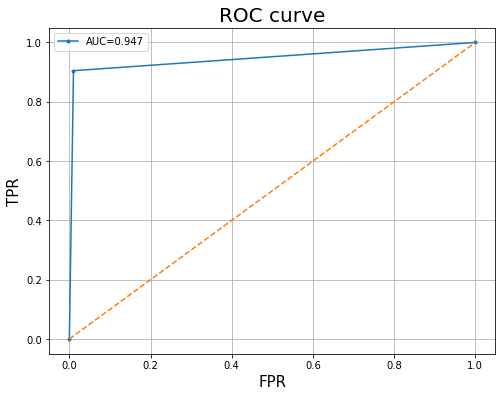

In [24]:
y_pred_test = lgbm.predict(X_test)
print(y_test.shape)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, y_pred_test)
auc = roc_auc_score(y_test,y_pred_test)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, marker='.')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC curve', fontsize = 20)
plt.xlabel('FPR', fontsize=15)
plt.ylabel('TPR', fontsize=15)
plt.grid()
plt.legend(["AUC=%.3f"%auc])
plt.show()

In [25]:
y_pred = np.ones((len(X_test),), dtype=int)
for i in range(len(y_pred_test)):
    if y_pred_test[i]<=0.5:
        y_pred[i]=0
    else:
        y_pred[i]=1
        
print('The percentage of misclassified points :',(1-accuracy_score(y_test, y_pred))*100)
print(sklearn.metrics.confusion_matrix(y_test, y_pred))

The percentage of misclassified points : 5.263796240145546
[[98056  1008]
 [ 9408 89408]]


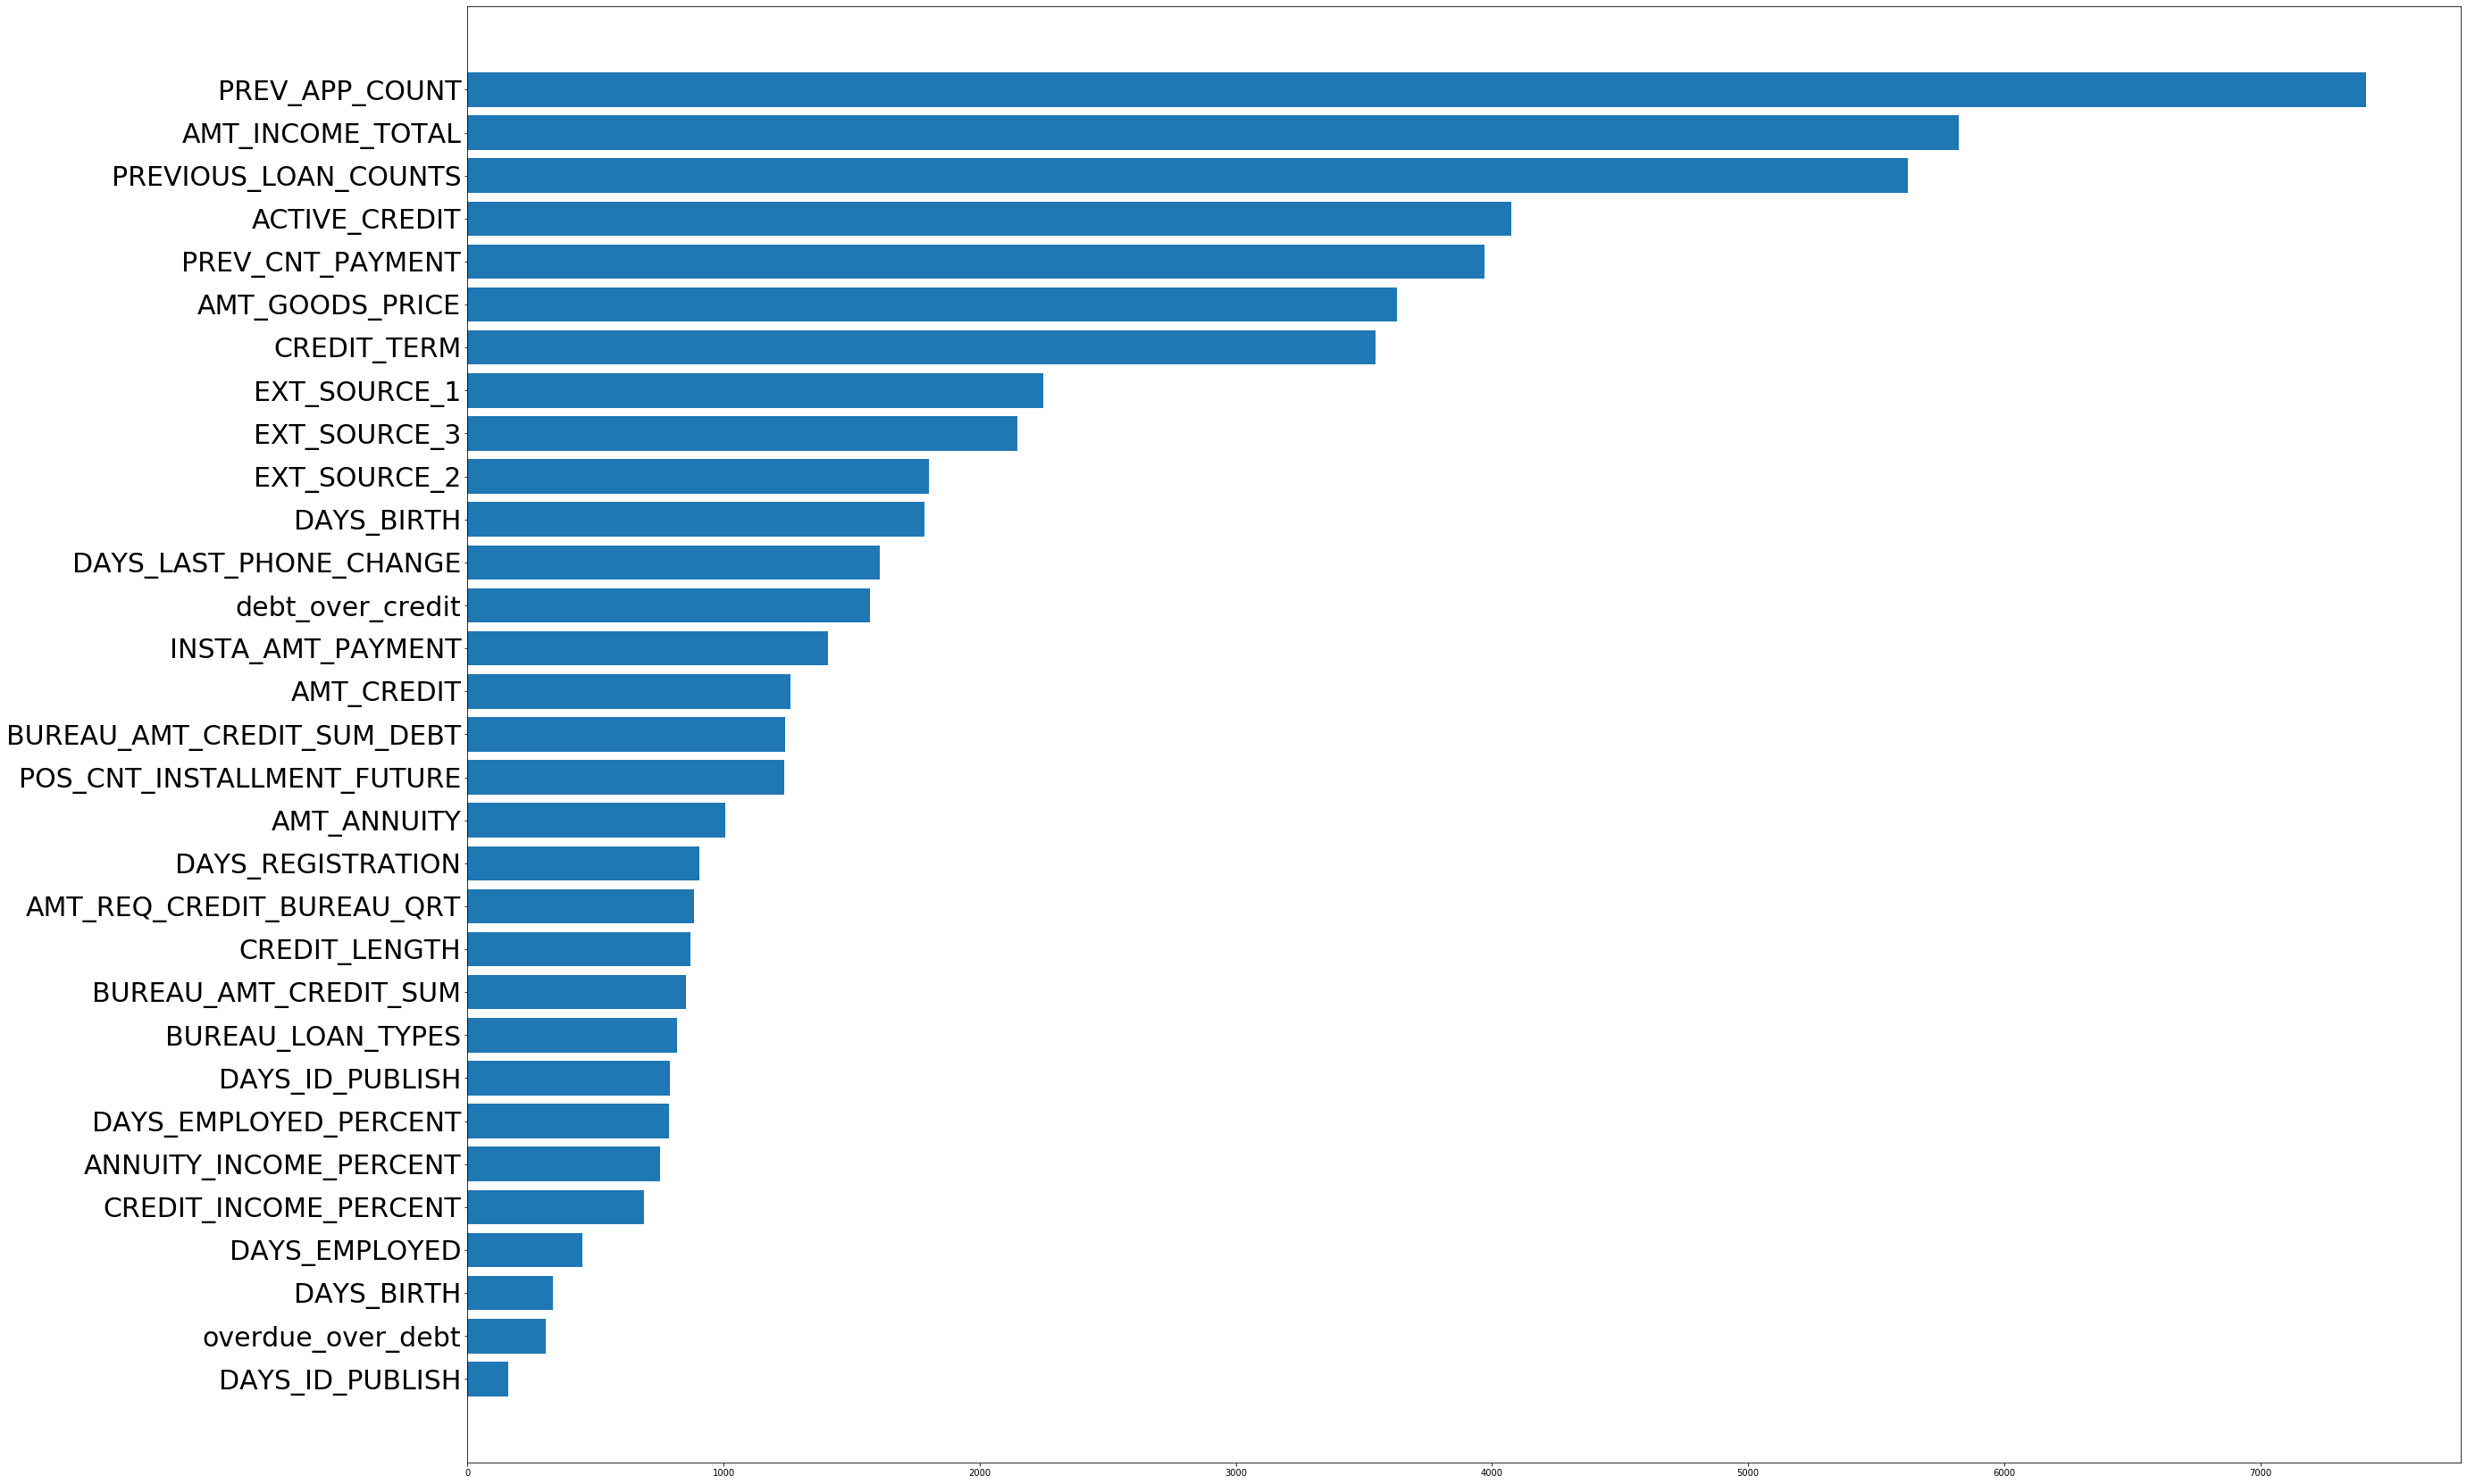

In [26]:
feature_map = list(zip(features,lgbm.feature_importances_))
feature_map.sort(key = lambda x:x[1])


features = [feature_map[i][0] for i in range(len(feature_map))]
feature_importance = [feature_map[i][1] for i in range(len(feature_map))]

plt.figure(figsize=(40,30))
y_pos = np.arange(len(features))
plt.barh(y_pos, feature_importance)
# # Create names on the y-axis
plt.yticks(y_pos, features,fontsize=30)
plt.show()



In [27]:
y_train=to_categorical(y_train)
y_val=to_categorical(y_val)
y_test=to_categorical(y_test)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(395760, 2)
(197880, 2)
(197880, 2)


In [28]:
model = Sequential()
model.add(Dense(31, input_dim=31, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1,validation_data=(X_val, y_val))
_, accuracy = model.evaluate(X_test, y_test, batch_size=32, verbose=1)

print(accuracy)

Epoch 1/20
12368/12368 [==============================] - 10s 833us/step - loss: 0.5692 - categorical_accuracy: 0.7055 - val_loss: 0.5494 - val_categorical_accuracy: 0.7205
Epoch 2/20
12368/12368 [==============================] - 10s 821us/step - loss: 0.5453 - categorical_accuracy: 0.7238 - val_loss: 0.5366 - val_categorical_accuracy: 0.7294
Epoch 3/20
12368/12368 [==============================] - 10s 813us/step - loss: 0.5325 - categorical_accuracy: 0.7329 - val_loss: 0.5220 - val_categorical_accuracy: 0.7403
Epoch 4/20
12368/12368 [==============================] - 10s 781us/step - loss: 0.5204 - categorical_accuracy: 0.7408 - val_loss: 0.5094 - val_categorical_accuracy: 0.7499
Epoch 5/20
12368/12368 [==============================] - 10s 814us/step - loss: 0.5039 - categorical_accuracy: 0.7518 - val_loss: 0.4939 - val_categorical_accuracy: 0.7569
Epoch 6/20
12368/12368 [==============================] - 11s 858us/step - loss: 0.4865 - categorical_accuracy: 0.7605 - val_loss: 0.47

In [34]:
y_pred = model.predict(X_test, batch_size=32, verbose=1)
y_pred = argmax(y_pred, axis=1)
#y_test = argmax(y_test, axis=1)
#y_train = argmax(y_train, axis=1)
#y_val = argmax(y_val, axis=1)

print(sklearn.metrics.classification_report(y_test, y_pred))
print('The percentage of misclassified points :',(1-accuracy_score(y_test, y_pred))*100)
print(sklearn.metrics.confusion_matrix(y_test, y_pred))

6184/6184 [==============================] - 4s 658us/step
              precision    recall  f1-score   support

           0       0.82      0.77      0.79     99064
           1       0.78      0.83      0.80     98816

    accuracy                           0.80    197880
   macro avg       0.80      0.80      0.80    197880
weighted avg       0.80      0.80      0.80    197880

The percentage of misclassified points : 20.081362441883964
[[76177 22887]
 [16850 81966]]


In [32]:
print('The percentage of misclassified points :',(1-accuracy_score(y_test, y_pred))*100)
print('The test AUC score is :', roc_auc_score(y_test,y_pred))

The percentage of misclassified points : 20.081362441883964
The test AUC score is : 0.7992242959188679


In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 31)                992       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               3200      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                6464      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 130       
Total params: 10,786
Trainable params: 10,786
Non-trainable params: 0
_________________________________________________________________
